### Loading

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils.segmentation import detect_iris, detect_pupil_edge_and_dilation, bounding_box_segmentation 
from utils.evaluation import evaluate_segmentation

In [2]:
import torch
import torchvision.transforms as T
from segment_anything import SamPredictor, sam_model_registry
import SimpleITK as sitk

In [20]:
image = cv2.imread("images/21.png") 
img_gt = np.load("images/21.npy")

In [21]:
from utils.detection import remove_overlapping_circles

### Iris and pupil detection

In [22]:
def detect_iris(image):
    # Step 1: Read the input image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Step 3: Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) for illumination normalization
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)

    # Step 4: Apply Gaussian blurring to reduce noise
    blurred = cv2.GaussianBlur(gray, (9, 9), 2)

    # Step 5: Perform Canny edge detection
    edges = cv2.Canny(blurred, threshold1=50, threshold2=10)#150

    # Step 6: Detect circles using HoughCircles
    circles = cv2.HoughCircles(edges, 
                               cv2.HOUGH_GRADIENT, 
                               dp=1, 
                               minDist=30, 
                               param1=100, 
                               param2=30, 
                               minRadius=20, 
                               maxRadius=100)
    circles = remove_overlapping_circles(circles)
    # Step 7: Draw detected circles (iris) on the original image
    if circles is not None:
        circles = np.uint16(np.around(circles))
        rr = [r for _, _, r in circles]
        index = np.argmax(rr)
        circle = circles[index]
        circles = [circle]
        for i in circles: #[0, :]
            # Draw the outer circle
            cv2.circle(gray, (i[0], i[1]), i[2], (255, 0, 0), 2)
            # Save the iris center for pupil detection
            iris_center = (i[0], i[1])
            iris_radius = i[2]
        print("Iris detected successfully.")
    else:
        print("No iris detected.")
        return
    

    return gray, blurred, edges, iris_center, iris_radius

In [23]:
gray, blurred, edges, iris_center, iris_radius = detect_iris(image)

Iris detected successfully.


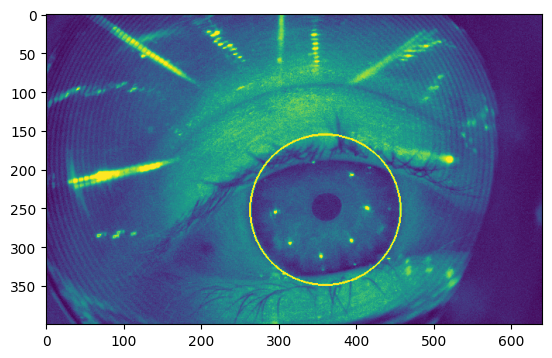

In [24]:
plt.imshow(gray)
plt.show()

Pupil detected.


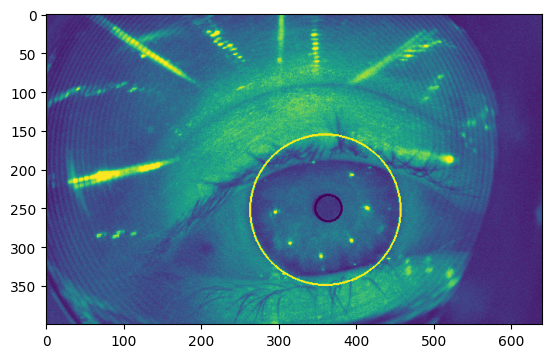

In [25]:
_, binary_mask = cv2.threshold(image[:,:,2], 45, 100, cv2.THRESH_BINARY_INV)
gray, pupil_center, pupil_radius = detect_pupil_edge_and_dilation(gray, binary_mask, iris_center, iris_radius)
plt.imshow(gray)
plt.show()

### Histogram visualization

In [26]:
#b, bins, patches = plt.hist(image.flatten(), 255)
#plt.xlim([0,255])
#plt.show()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
image = clahe.apply(gray)
image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
#b, bins, patches = plt.hist(image.flatten(), 255)
#plt.xlim([0,255])
#plt.show()

### Sclera Segmentation with Segment Anything model

In [27]:
# Load the SAM model
model_type = "vit_b" 
model_path = "models/sam_vit_b_01ec64.pth" 

sam = sam_model_registry[model_type](checkpoint=model_path)
sam.eval()
predictor = SamPredictor(sam)
predictor.set_image(image)

c:\Users\hohih\optimeyes\venv\Lib\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [28]:
def sclera_segmentation(image, predictor):
    # Define foreground points
    point_coords = np.array([[250, 310], [500, 250], [250, 250]])  
    point_labels = np.array([1, 1, 1])  

    # Background points
    background_coords = np.array([[350,150], [350, 370],[150,350]])  # Outside the sclera
    background_labels = np.array([0, 0, 0])

    # Combine the points
    point_coords = np.concatenate((point_coords, background_coords), axis=0)
    point_labels = np.concatenate((point_labels, background_labels), axis=0)

    masks, scores, logits = predictor.predict(
    point_coords=point_coords,
    point_labels=point_labels,
    multimask_output=False  # Generate multiple segmentation masks
    )
    best_mask_index = np.argmax(scores)  # Choose the mask with the highest score
    sclera_mask = masks[best_mask_index]
    print('Number of masks found', len(masks))
    ### Bounding Box input
    # Estimate eye location (you may need to adjust these values)
    # h, w = image.shape[:2]
    # box = np.array([100, 600, 150, 350]) #[w*0.2, h*0.2, w*0.8, h*0.8])
    # masks, _, _ = predictor.predict(box=box[None, :], multimask_output=False)
    return sclera_mask

Number of masks found 1


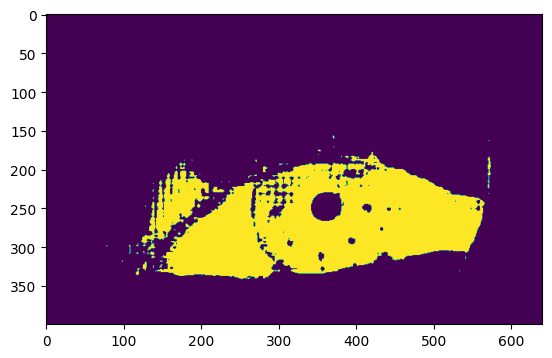

In [29]:
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Apply histogram equalization
enhanced_image = cv2.equalizeHist(gray_image)
# Convert the grayscale image back to a 3-channel image
enhanced_image_rgb = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2RGB)
predictor.set_image(enhanced_image_rgb)
box_mask = sclera_segmentation(enhanced_image_rgb, predictor)
plt.imshow(box_mask)
plt.show()

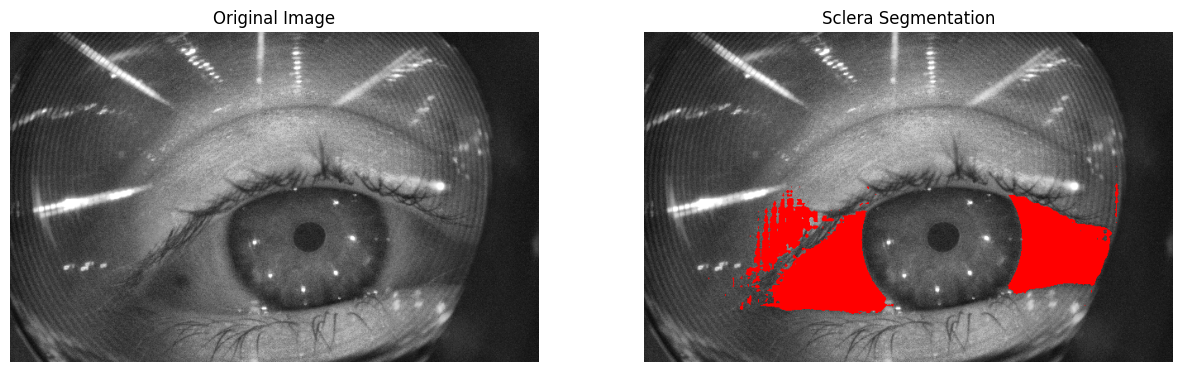

In [30]:
# Filter out contours inside the iris region
iris_mask = np.zeros_like(gray)
cv2.circle(iris_mask, iris_center, iris_radius, 255, thickness=-1)
# Apply the iris mask to the binary mask
no_iris_mask = cv2.bitwise_not(iris_mask)
no_iris_image = cv2.bitwise_and(gray, no_iris_mask)
final_sclera_mask = cv2.bitwise_and(box_mask.astype(np.uint8), no_iris_mask)

# Create a copy of the original image for visualization
segmented_image = image.copy()
# Apply the mask to the image
segmented_image[final_sclera_mask == 1] = [255, 0, 0]  # Color the mask area red for visualization
# Plot the original image and the segmented result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.imshow(image)
ax1.set_title("Original Image")
ax1.axis("off")

ax2.imshow(segmented_image)
ax2.set_title("Sclera Segmentation")
ax2.axis("off")

plt.show()


### Segmentation result and evaluation

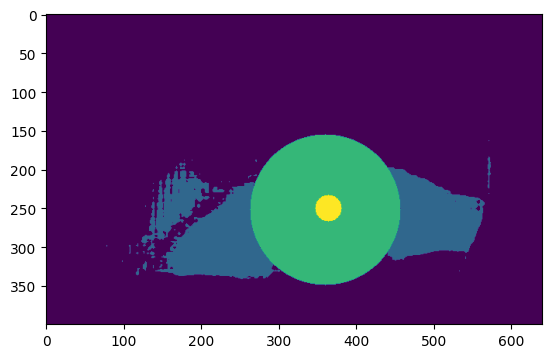

In [31]:
pred_img_shape = gray.shape
pred_img = np.zeros(pred_img_shape, dtype=np.uint8)
cv2.circle(pred_img, iris_center, iris_radius, 2, thickness=-1)
cv2.circle(pred_img, pupil_center, pupil_radius, 3, thickness=-1)
pred_img[final_sclera_mask == 1] = 1

plt.imshow(pred_img)
plt.show()

In [32]:
from collections import Counter
flat_img = pred_img.flatten()
coun = Counter(flat_img)
coun

Counter({0: 203140, 2: 28624, 1: 23335, 3: 901})

In [33]:
metrics = evaluate_segmentation(pred_img, img_gt)

Segmentation metrics per class:
Background:
  IOU: 0.9401
  dice: 0.9691
  acc: 0.9496
Sclera:
  IOU: 0.6722
  dice: 0.8040
  acc: 0.9688
Iris:
  IOU: 0.7891
  dice: 0.8821
  acc: 0.9764
Pupil:
  IOU: 0.7738
  dice: 0.8725
  acc: 0.9990
